# Choosing the Right Metric

This module introduced both the K Nearest Neighbors model as well as a variety of different metrics for classification.  It is important to select and understand the appropriate metric for your task.  This exercise is meant to get practice considering the difference between these new classification metrics and accompanying evaluation tools. Specifically, explore datasets related to business from the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/datasets).  

Select a dataset of interest and clearly state the classification task.  Specifically, describe a business problem that could be solved using the dataset and a KNN classification model.  Further, identify what you believe to be the appropriate metric and justify your choice.  Build a basic model with the `KNearestNeighbor` and grid search to optimize towards your chosen metric.  Share your results with your peers.

# Imports

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

from scipy.io import arff as arff_io

In [3]:
warnings.filterwarnings("ignore")
np.random.seed(1234)
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (16, 4)})
sns.set()

# Data Load

Rice data set, from UCI's machine learning data repository, [here](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik).

In [4]:
arff_contents = arff_io.loadarff("./data/Rice_Cammeo_Osmancik.arff")
df = pd.DataFrame(arff_contents[0])
df

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,b'Cammeo'
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,b'Cammeo'
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,b'Cammeo'
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,b'Cammeo'
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,b'Cammeo'
...,...,...,...,...,...,...,...,...
3805,11441.0,415.858002,170.486771,85.756592,0.864280,11628.0,0.681012,b'Osmancik'
3806,11625.0,421.390015,167.714798,89.462570,0.845850,11904.0,0.694279,b'Osmancik'
3807,12437.0,442.498993,183.572922,86.801979,0.881144,12645.0,0.626739,b'Osmancik'
3808,9882.0,392.296997,161.193985,78.210480,0.874406,10097.0,0.659064,b'Osmancik'


In [5]:
df["Class"] = df["Class"].str.decode("ascii")

In [6]:
df

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,Cammeo
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,Cammeo
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,Cammeo
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,Cammeo
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,Cammeo
...,...,...,...,...,...,...,...,...
3805,11441.0,415.858002,170.486771,85.756592,0.864280,11628.0,0.681012,Osmancik
3806,11625.0,421.390015,167.714798,89.462570,0.845850,11904.0,0.694279,Osmancik
3807,12437.0,442.498993,183.572922,86.801979,0.881144,12645.0,0.626739,Osmancik
3808,9882.0,392.296997,161.193985,78.210480,0.874406,10097.0,0.659064,Osmancik


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(7), object(1)
memory usage: 238.2+ KB


Text(0.5, 1.0, 'Count of Rice Types')

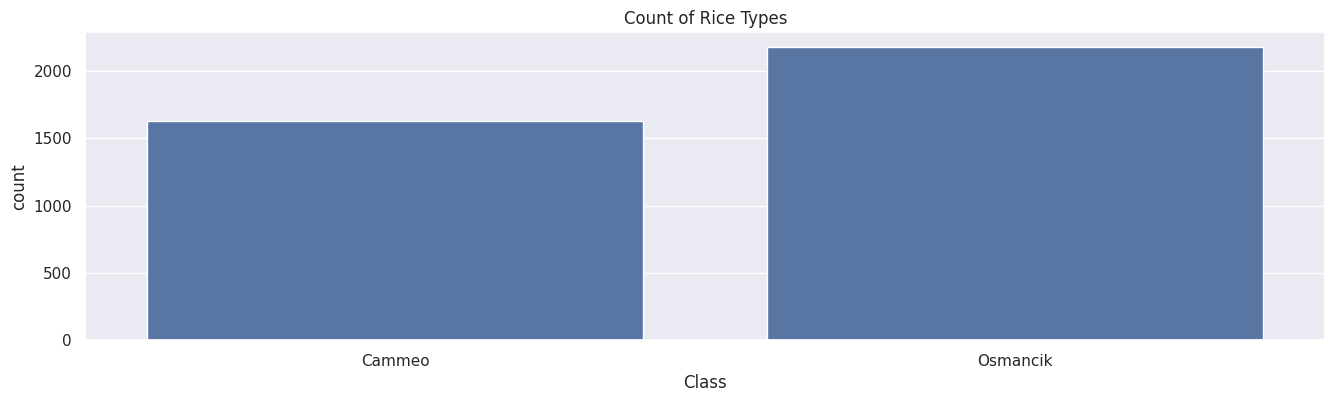

In [8]:
sns.countplot(data=df, x="Class")
plt.title("Count of Rice Types")

# Data Set Up

## Shuffle the Data

Because it is all Cammeo, then all Osmancik

In [9]:
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
df

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,12442.0,459.535004,187.508850,87.187302,0.885323,12941.0,0.587580,Cammeo
1,12408.0,437.014008,179.741165,88.829605,0.869343,12598.0,0.636928,Osmancik
2,12867.0,449.079987,181.700562,91.341064,0.864460,13152.0,0.649062,Osmancik
3,13090.0,472.945007,202.601578,83.230179,0.911722,13331.0,0.775290,Cammeo
4,10359.0,409.510986,173.337967,76.875809,0.896273,10510.0,0.573588,Osmancik
...,...,...,...,...,...,...,...,...
3805,16625.0,535.989014,229.793594,93.089622,0.914272,16951.0,0.654141,Cammeo
3806,13901.0,478.848999,200.441910,89.341988,0.895170,14232.0,0.568548,Cammeo
3807,16291.0,523.192993,223.252335,93.604156,0.907859,16595.0,0.581157,Cammeo
3808,10847.0,417.924011,170.366791,82.473007,0.875018,11107.0,0.746319,Osmancik


## Split into X=features and y=target

In [10]:
X, y = df.drop(columns=["Class"]), df["Class"]
y

0         Cammeo
1       Osmancik
2       Osmancik
3         Cammeo
4       Osmancik
          ...   
3805      Cammeo
3806      Cammeo
3807      Cammeo
3808    Osmancik
3809    Osmancik
Name: Class, Length: 3810, dtype: object

Also map the target. Don't have to do this, but it makes the confusion matrices a bit easier to work with

In [11]:
target_map = {"Cammeo": 0, "Osmancik": 1}
y = y.map(target_map)
y

0       0
1       1
2       1
3       0
4       1
       ..
3805    0
3806    0
3807    0
3808    1
3809    1
Name: Class, Length: 3810, dtype: int64

## Split into Training and Dev

And stratify to keep balance of classes same

In [12]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=42, stratify=y)

In [13]:
y.value_counts(normalize=True)

Class
1    0.572178
0    0.427822
Name: proportion, dtype: float64

# Model Definition

Pipeline of
- Scaling on the features - all already numeric
- KNeighborsClassifier classifier


In [14]:
knn_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier()),
    ]
)

knn_pipe

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# Grid Search

What's the best metric here? Not sure yet!

## Make Estimators that Optimize Each of 5 Metrics

In [15]:
n_neighbors_list = list(range(1, 102, 2))
n_neighbors_list = [1, 5, 10, 50, 100, 500, 1000, 2000]
param_grid = {"knn__n_neighbors": n_neighbors_list}
param_grid

{'knn__n_neighbors': [1, 5, 10, 50, 100, 500, 1000, 2000]}

In [16]:
# metrics_list = ["accuracy", "precision", "recall", "f1", "roc_auc"]
metrics_list = ["accuracy", "recall", "f1"]

In [17]:
knn_estimators = {
    metric: GridSearchCV(
        estimator=knn_pipe,
        param_grid=param_grid,
        scoring=metric,
        cv=5,
    ).fit(X_train, y_train)
    for metric in metrics_list
}

knn_estimators

{'accuracy': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('knn', KNeighborsClassifier())]),
              param_grid={'knn__n_neighbors': [1, 5, 10, 50, 100, 500, 1000,
                                               2000]},
              scoring='accuracy'),
 'recall': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('knn', KNeighborsClassifier())]),
              param_grid={'knn__n_neighbors': [1, 5, 10, 50, 100, 500, 1000,
                                               2000]},
              scoring='recall'),
 'f1': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('knn', KNeighborsClassifier())]),
              param_grid={'knn__n_neighbors': [1, 5, 10, 50, 100, 500, 1000,
                                               2000]},
             

# Plots and Analysis

In [18]:
def make_scores_dict(estimator):
    all_metrics_list = ["accuracy", "precision", "recall", "f1"]
    estimator.fit(X_train, y_train)
    y_dev_preds = estimator.predict(X_dev)
    scores_dict = {
        metric: round(eval(metric + "_score")(y_dev, y_dev_preds), 2)
        for metric in all_metrics_list
    }
    return scores_dict, y_dev_preds

In [19]:
make_scores_dict(knn_pipe)[0]

{'accuracy': 0.91, 'precision': 0.92, 'recall': 0.92, 'f1': 0.92}

In [20]:
estimator = knn_pipe
estimator.named_steps["knn"].n_neighbors = 5
estimator.fit(X_train, y_train)
y_dev_preds = estimator.predict(X_dev)
accuracy_score(y_dev, y_dev_preds) * 100.0

91.18572927597062

## Metrics vs. Num Neighbors

In [21]:
all_scores = {metric: [] for metric in metrics_list}
for n_neighbors in n_neighbors_list:
    knn_pipe.named_steps["knn"].n_neighbors = n_neighbors
    scores = make_scores_dict(knn_pipe)[0]
    for metric in metrics_list:
        all_scores[metric].append(scores[metric])

Text(0.5, 1.0, 'Metric vs. Number of Neighbors, Scored on Dev Set')

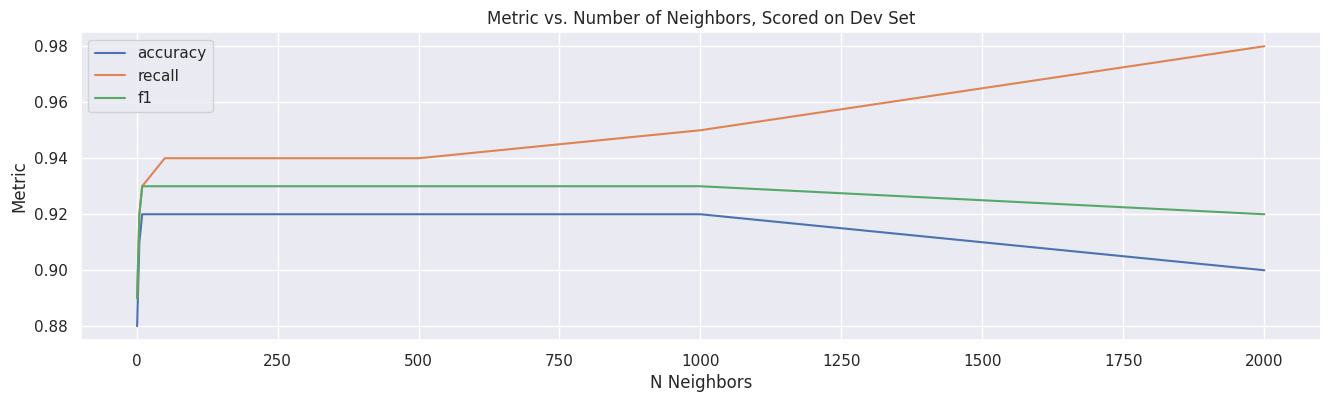

In [22]:
for metric in metrics_list:
    plt.plot(n_neighbors_list, all_scores[metric], label=metric)

plt.legend()
plt.xlabel("N Neighbors")
plt.ylabel("Metric")
plt.title("Metric vs. Number of Neighbors, Scored on Dev Set")

## DecisionBoundaryDisplay

For a limited number of neighbors

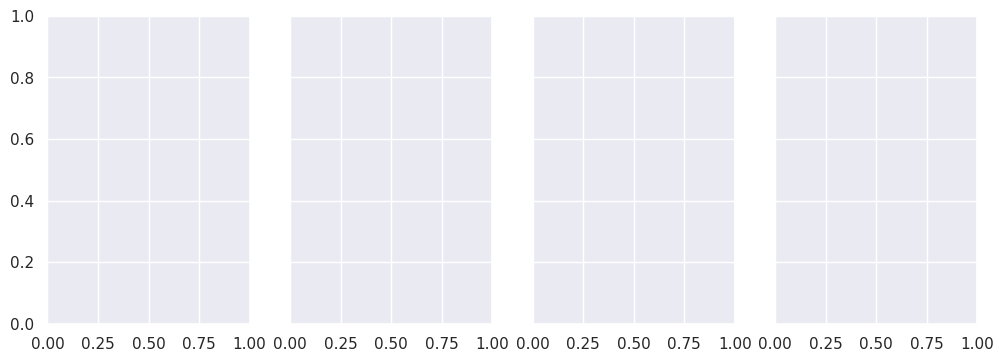

In [23]:
n_neighbors_list_small = [1, 5, 10, 50]
fig, ax = plt.subplots(
    1, len(n_neighbors_list_small), sharex="col", sharey="row", figsize=(12, 4)
)

if 0:
    for k in range(len(n_neighbors_list_small)):
        n_neighbors = n_neighbors_list_small[k]
        knn_pipe.named_steps["knn"].n_neighbors = n_neighbors
        plot_features = ["Area", "Perimeter"]
        knn_pipe.fit(X_train[plot_features], y_train)
        DecisionBoundaryDisplay.from_estimator(
            knn_pipe, X_train[plot_features], alpha=0.4, response_method="predict", ax=ax[k]
        )

        acc = accuracy_score(y_dev, knn_pipe.predict(X_dev[plot_features]))
        ax[k].set_title("n_neighbors = %d\naccuracy = %.2f" % (n_neighbors, acc))


## ROC Curves for Each Scoring Function

Text(0.5, 1.0, 'ROC Curve')

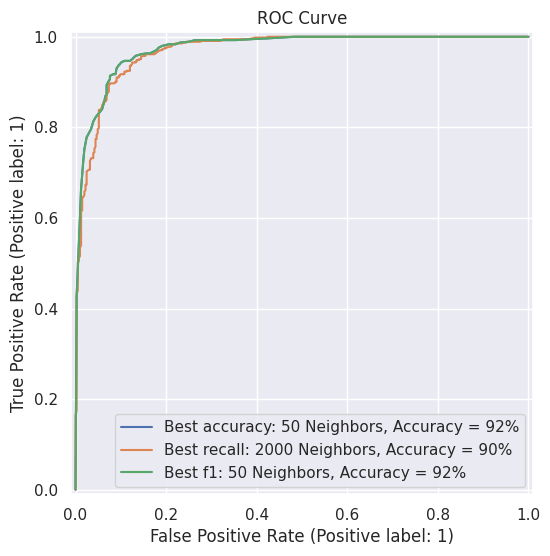

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 6))

for metric in metrics_list:
    estimator_grid = knn_estimators[metric]
    estimator = estimator_grid.best_estimator_.fit(X_train, y_train)
    scores = make_scores_dict(estimator)[0]
    RocCurveDisplay.from_estimator(
        estimator,
        X_dev,
        y_dev,
        ax=ax,
        label="Best %s: %d Neighbors, Accuracy = %d%%"
        % (
            metric,
            estimator_grid.best_params_["knn__n_neighbors"],
            scores["accuracy"] * 100.0,
        ),
    )

plt.title("ROC Curve")

## Confusion Matrices for Each Scoring Function

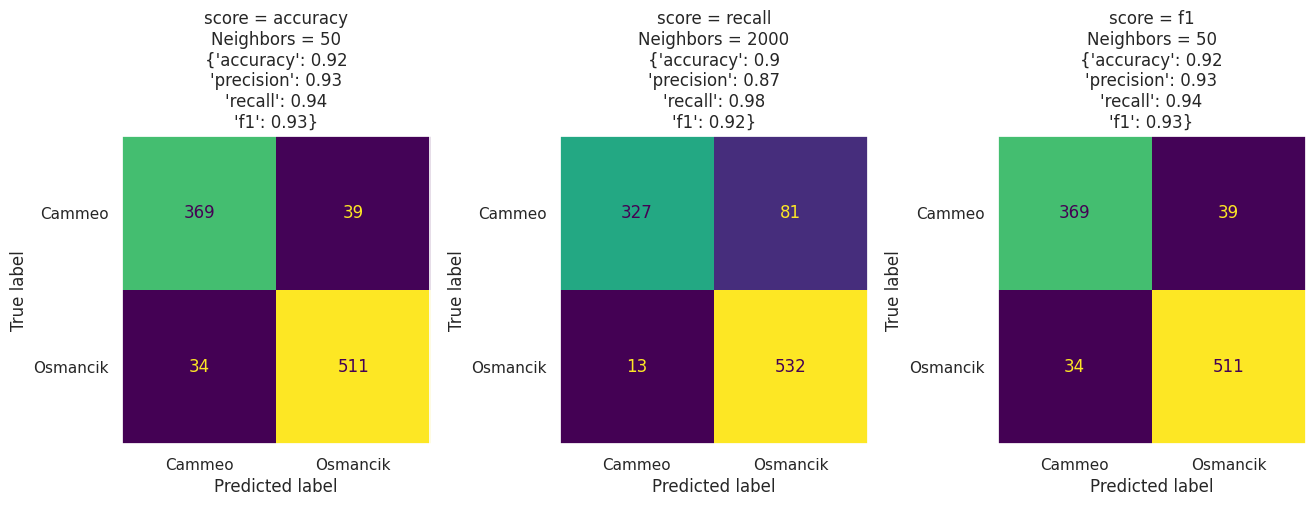

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=len(metrics_list))
for k in range(len(metrics_list)):
    metric = metrics_list[k]
    estimator_grid = knn_estimators[metric]
    estimator = estimator_grid.best_estimator_.fit(X_train, y_train)
    scores, y_dev_preds = make_scores_dict(estimator)
    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_dev,
        y_dev_preds,
        display_labels=target_map.keys(),
        ax=ax[k],
        colorbar=False,
    )
    title_str = "score = %s\nNeighbors = %d\n%s" % (
        metric,
        estimator_grid.best_params_["knn__n_neighbors"],
        str(scores).replace(", ", "\n"),
    )
    ax[k].set_title(title_str)
    ax[k].grid(False)

## Classification Report

In [26]:
print(
    classification_report(
        y_dev, estimator.predict(X_dev), target_names=list(target_map.keys())
    )
)

              precision    recall  f1-score   support

      Cammeo       0.92      0.90      0.91       408
    Osmancik       0.93      0.94      0.93       545

    accuracy                           0.92       953
   macro avg       0.92      0.92      0.92       953
weighted avg       0.92      0.92      0.92       953



## Precision/Recall Curve

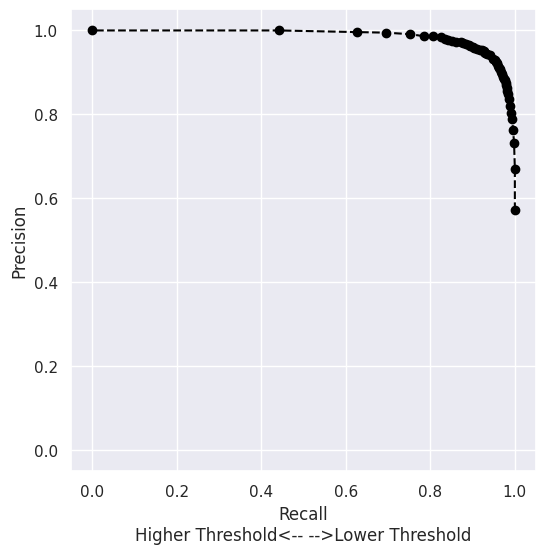

In [27]:
precision, recall, thresholds = precision_recall_curve(
    y_train, estimator.predict_proba(X_train)[:, 1], pos_label=1,
)

fix, ax1 = plt.subplots(figsize=(6,6))
ax1.plot(
    recall,
    precision,
    color="black",
    marker="o",
    linestyle="dashed",
)

ax1.set_xlabel("Recall\nHigher Threshold<-- -->Lower Threshold")
ax1.set_ylabel("Precision")
ax1.set_xlim(left=-0.05, right=1.05)
ax1.set_ylim(bottom=-0.05, top=1.05)

if 0:
    ax2_color = "blue"
    ax2 = ax1.twinx()
    ax2.plot(
        thresholds,
        thresholds,
        linestyle="solid",
        marker="o",
        color=ax2_color,
    )

    ax2.set_ylabel("Threshold", color=ax2_color)
    ax2.tick_params(axis="y", labelcolor=ax2_color)